In [22]:
# ©2023 The Johns Hopkins University Applied Physics Laboratory LLC
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from scipy.interpolate import splev,splrep

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

from tensorflow import keras
from tensorflow.keras import layers

In [23]:
def interpolate(df1,df2) -> tuple:
    x1 = np.array([])
    v1 = np.array([])
    prevV = -99999
    for i in range(len(df1)):
        if i%35==0 and df1[i] == 0:
            x1 = np.append(x1,i)
            v1 = np.append(v1,0)
            prevV = 0
        elif prevV != df1[i]:
            if(df1[i] > 5):
                print(a)
            x1 = np.append(x1,i)
            v1 = np.append(v1,df1[i])
            prevV = df1[i]
    tck1 = splrep(x1, v1)
    
    x2 = np.array([])
    v2 = np.array([])
    prevV = -99999
    for i in range(len(df2)):
        if i%35==0 and df2[i] == 0:
            x2 = np.append(x2,i+5100)
            v2 = np.append(v2,0)
            prevV = 0
        elif prevV != df2[i]:
            x2 = np.append(x2,i+5100)
            v2 = np.append(v2,df1[i])
            prevV = df2[i]
    tck2 = splrep(x2, v2)
    
    vArray = np.array([])
    vel1 = np.array([])
    vel2 = np.array([])
    for i in range(0,5100):
        vel1 = np.append(vel1,splev(i, tck1))
    for i in range(5100,10200):
        vel2 = np.append(vel2,splev(i, tck2))
    
    pvel1 = np.append(0,vel1)
    pvel2 = np.append(0,vel2)
    pvel1 = vel1[:5100]
    pvel2 = vel2[:5100]
    pvel1 = np.random.normal(pvel1, 0.25)
    pvel2 = np.random.normal(pvel2, 0.25)
    return vel1,vel2,pvel1,pvel2

In [24]:
df1 = pd.read_csv(r"C:\Users\yusj1\Documents\Python_Scripts\DeadReckoningTest\5min_data1.csv")
df2 = pd.read_csv(r"C:\Users\yusj1\Documents\Python_Scripts\DeadReckoningTest\5min_data2.csv")
df3 = pd.read_csv(r"C:\Users\yusj1\Documents\Python_Scripts\DeadReckoningTest\5min_data3.csv")

In [25]:
df1.drop(df1.tail(2).index,inplace=True)
df2.drop(df2.tail(2).index,inplace=True)

df1_labels = df1.pop('V').to_numpy()
df2_labels = df2.pop('V').to_numpy()

df1.pop('Prev V')
df2.pop('Prev V')

label1,label2,prevdf1,prevdf2 = interpolate(df1_labels, df2_labels)

df1['Prev V'] = prevdf1
df2['Prev V'] = prevdf2


In [5]:
train_labels = label1[140]
train_labels = np.expand_dims(train_labels, 0)
numLabels = len(label1)
for i in range (141, numLabels):
    temp = label1[i]
    temp = np.expand_dims(temp,0)
    train_labels = np.concatenate((train_labels,temp))

for i in range (140, numLabels):
    temp = label2[i]
    temp = np.expand_dims(temp,0)
    train_labels = np.concatenate((train_labels,temp))

array = df1.iloc[:140].to_numpy()
numRows = len(df1.index)
print(numRows)
df1.drop(df1.head(1).index,inplace=True)
array = np.expand_dims(array, 0)
for i in range(0, numRows-140-1):
    temp = df1.iloc[:140].to_numpy()
    temp = np.expand_dims(temp,0)
    df1.drop(df1.head(1).index,inplace=True)
    array = np.concatenate((array,temp))

#change times
for i in range(0, numRows-140-1):
    firstValue = array[i][0][6]
    for j in range(0, 140):
        array[i][j][6] = (array[i][j][6] - firstValue)
        

array2 = df2.iloc[:140].to_numpy()
df2.drop(df2.head(1).index,inplace=True)
array2 = np.expand_dims(array2, 0)
for i in range(0, numRows-140-1):
    temp = df2.iloc[:140].to_numpy()
    temp = np.expand_dims(temp,0)
    df2.drop(df2.head(1).index,inplace=True)
    array2 = np.concatenate((array2,temp))
for i in range(0, numRows-140-1):
    firstValue1 = array2[i][0][6]
    for j in range(0, 140):
        array2[i][j][6] = (array2[i][j][6] - firstValue1)  
        
train_features = np.concatenate((array, array2))  


5100


In [6]:
# train_labels = np.expand_dims(train_labels, 1)
print(train_labels.shape)
print(train_features.shape)

(9920,)
(9920, 140, 8)


In [7]:
model = tf.keras.Sequential([
    layers.Conv1D(filters=16,
                    kernel_size=3,
                    activation='relu',
                    input_shape = (140,8),
                    batch_size = 32),
    layers.Flatten(),
    layers.Dense(units=1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error','mean_squared_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (32, 138, 16)             400       
                                                                 
 flatten (Flatten)           (32, 2208)                0         
                                                                 
 dense (Dense)               (32, 1)                   2209      
                                                                 
Total params: 2,609
Trainable params: 2,609
Non-trainable params: 0
_________________________________________________________________


(140, 8)


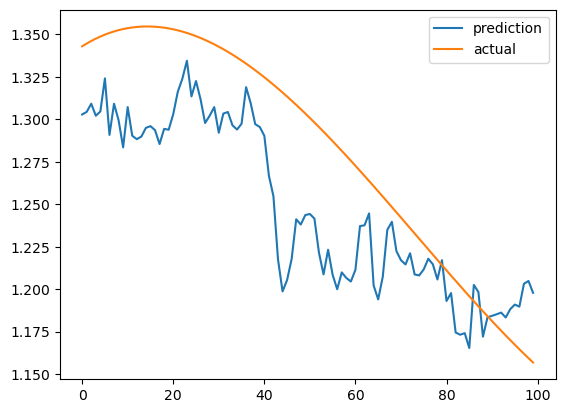

In [9]:
print(train_features[1].shape)
arr = model(train_features[400:500], training=False)
v = train_labels[400:500]
plt.plot(arr, label="prediction")
plt.plot(v, label="actual")
plt.legend()
plt.show()

In [10]:
loss = history.history['loss']

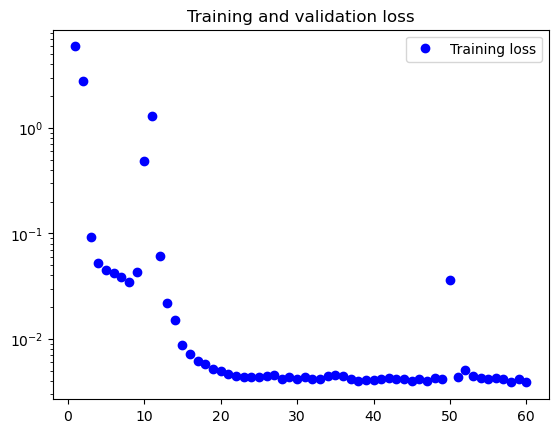

In [11]:
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.semilogy()
plt.legend()

plt.show()


In [12]:
model.save('model_exprmt2', save_format='tf')

INFO:tensorflow:Assets written to: model_exprmt2\assets


INFO:tensorflow:Assets written to: model_exprmt2\assets


In [13]:
def interpolateOne(df1) -> tuple:
    x1 = np.array([])
    v1 = np.array([])
    prevV = -99999
    for i in range(len(df1)):
        if i%35==0 and df1[i] == 0:
            x1 = np.append(x1,i)
            v1 = np.append(v1,0)
            prevV = 0
        elif prevV != df1[i]:
            x1 = np.append(x1,i)
            v1 = np.append(v1,df1[i])
            prevV = df1[i]
    tck1 = splrep(x1, v1)
    vel1 = np.array([])
    for i in range(0,len(df1)):
        vel1 = np.append(vel1,splev(i, tck1))
    
    pvel1 = np.append(0,vel1)
    pvel1 = vel1[:len(df1)]
    return vel1,pvel1

In [14]:
a =pd.read_csv(r"C:\Users\yusj1\Documents\Python_Scripts\DeadReckoningTest\trail1_data.csv")

test = a.copy()

test.pop('Prev V')
test.pop('X Vel')
test.pop('Y Vel')
test.pop('Z Vel')
test.pop('Lat')
test.pop('Long')
l = test.pop('V')
prev_test = test.copy()

labelt,prevdft = interpolateOne(l)

test['Prev V'] = prevdft

test_labels = labelt[140]
test_labels = np.expand_dims(test_labels, 0)
numLabels = len(labelt)
for i in range (141, numLabels):
    temp = labelt[i]
    temp = np.expand_dims(temp,0)
    test_labels = np.concatenate((test_labels,temp))

array = test.iloc[:140].to_numpy()
numRows = len(test.index)
print(numRows)
test.drop(test.head(1).index,inplace=True)
array = np.expand_dims(array, 0)
for i in range(0, numRows-140-1):
    temp = test.iloc[:140].to_numpy()
    temp = np.expand_dims(temp,0)
    test.drop(test.head(1).index,inplace=True)
    array = np.concatenate((array,temp))
for i in range(0, numRows-140-1):
    firstValue = array[i][0][6]
    for j in range(0, 140):
        array[i][j][6] = (array[i][j][6] - firstValue)


5322


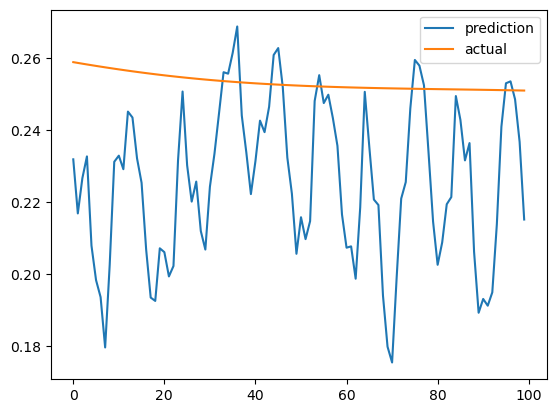

In [15]:
n = 1200

test_predictions = model(array[n:n+100], training=False)
actual_values = test_labels[n:n+100]

plt.plot(test_predictions, label="prediction")
plt.plot(actual_values, label="actual")
plt.legend()
plt.show()

In [16]:
results = model.evaluate(array, test_labels, batch_size=32)

162/162 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_absolute_error: 0.0834 - mean_squared_error: 0.0231


In [18]:
k = len(prev_test.index)
prev_test['Prev V'] = [0]*len(prev_test.index)

temp = prev_test

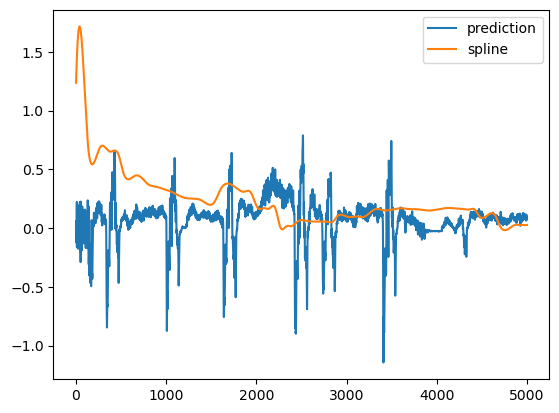

In [20]:

plt.plot(v_array[0:5000], label="prediction")
plt.plot(test_labels[0:5000], label="spline")
plt.legend()
plt.show()

In [21]:
pd.DataFrame(v_array).to_csv('predictedvalue01.csv')